# FRAMEWORK FOR PROCESSING AUDIO FILES APPLIED TO CLASSIFICATION OF RESPIRATORY DISEASES

For an introduction to feature extraction from audio files see
https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d
and later:
https://medium.com/@sdoshi579/classification-of-music-into-different-genres-using-keras-82ab5339efe0

## BASIC FEATURES
### CONTROLLED SIZE MEL SPECTOGRAM (librosa.feature.melspectrogram())

see https://github.com/josehs1986/Audio-Preprocessing/blob/audio/Melspectogram_Constant_Shape_Feature_Matrix.ipynb


PARTS OF THIS NOTEBOOK WERE COPIED FROM BreathCycleClassification_v3_May30 (Isuru Sachitha @ kaggle)


# BASIC LIBRARIES

In [1]:

import matplotlib.pyplot as plt

import seaborn as sns
import librosa

import soundfile as sf

import librosa.display

from scipy import signal
from scipy import stats
from scipy.io import wavfile

from pydub import AudioSegment

import IPython
import IPython.display as ipd
from IPython.display import Audio, Javascript

from tqdm import tqdm

from skimage.restoration import denoise_wavelet

# MODELS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# BASIC METRICS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import multilabel_confusion_matrix

# VALIDATION METHODS
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# FEATURE SELECTION METHODS
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector

# GENERAL USE LIBRARIES
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import itertools

from operator import truediv

import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from os import listdir
from os.path import isfile, join

# for dirname, _, filenames in os.walk('C:/Users/diego/Google Drive/IA/datasets/respiratory_sound'): #('/kaggle/input'):
#     for filename in filenames:
#         #print(os.path.join(dirname, filename))
#         pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


c:\users\diego\miniconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# METHODS'S SUIT

In [2]:
# get a list of models to evaluate

def get_models(n_neighbors=10, kernel='poly', C=1, solver='lbfgs',hidden_layer_sizes=(100,50),max_iter=1000):
    models = list()
    models.append(KNeighborsClassifier(n_neighbors=n_neighbors))
#     models.append(SVC(kernel=kernel, C=C))
#     models.append(MLPClassifier(solver=solver,hidden_layer_sizes=hidden_layer_sizes,max_iter=max_iter))
#     models.append(LogisticRegression())
#     models.append(RidgeClassifier())
#     models.append(SGDClassifier())
#     models.append(PassiveAggressiveClassifier())
#     models.append(DecisionTreeClassifier())
#     models.append(ExtraTreeClassifier())
#     models.append(LinearSVC())
#     models.append(GaussianNB())
#     models.append(AdaBoostClassifier())
#     models.append(BaggingClassifier())
    models.append(RandomForestClassifier())
#     models.append(ExtraTreesClassifier())
#     models.append(GradientBoostingClassifier())
#     models.append(LinearDiscriminantAnalysis())
#     models.append(QuadraticDiscriminantAnalysis())
#     models.append(GaussianProcessClassifier())    # too slow and not he best !!!
    return models

# AUXILIARY FUNCTIONS

In [3]:
# evaluate the model using a given test condition
# inputs: cv = test conditions, model=model, X, y = data and labels, metric = metric

def evaluate_model(cv, model, X, y, metric):
    
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    
    # return scores
    return np.mean(scores)


In [4]:
# COMPARISON OF MODELS WITH USING CROSS-VALIDATION

def Compare_Models(X,Y,n_splits=5,random_state=142):

    #selected number of features
    feat_nmb=X.shape[1]

    # define test conditions

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # get the list of models to consider
    models = get_models() # n_neighbors=10, kernel='poly', C=1, solver='lbfgs',hidden_layer_sizes=(30)

    # set lists to collect results
    cv_results = list()

    # evaluate each model

    metric='accuracy'   

    ctr=1
    
    for model in models:

        # evaluate model using each test condition
        cv_mean = evaluate_model(cv, model, X[:,:feat_nmb], Y, metric)

        # check for invalid results
        if np.isnan(cv_mean): 
            continue

        # store results
        cv_results.append(cv_mean)

        # summarize progress
        print('%d>%s:, cv=%.3f' % (ctr,type(model).__name__, cv_mean))
        ctr+=1

    ord_index=np.argsort(cv_results)

    model=models[ord_index[-1]]
    print()
    print("best classifier with all features:",model,metric,round(cv_results[ord_index[-1]],4))

    for i in range(len(models)):
        plt.bar(models[i].__class__.__name__,cv_results[i])
    plt.xticks(rotation=90.0)#direction='out', length=6, width=2, colors='r',grid_color='r', grid_alpha=0.5)
    plt.show()
    
    return(model)


In [5]:
# SEQUENTIAL FEATURE SELECTION FOR A GIVEN MODEL LIST

def Feature_Selector(models,X,Y,feature_names,n_splits=5,random_state=142):
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    if len(feature_names)==0:
        feature_names=np.arange(X.shape[1])
        
    best_features_indexes=[]
    best_features_names=[]
    max_scores=[]
    
    nf=X.shape[1]
    
    for model in models: 

        print()
        print(model)
        
        max_score=-1

        for n_features_to_select in range(1,nf): 

            # # number of feature combinations 
            # ncombs=1
            # if sel_feat<n_components:
            #     ncombs = math.factorial(n_components)/math.factorial(n_components-sel_feat)/math.factorial(sel_feat)    
            # print(ncombs)    

            sfs = SequentialFeatureSelector(estimator=model, n_features_to_select=n_features_to_select).fit(X, Y)

            X_sel=sfs.transform(X)

            selected=sfs.get_support()

            sel_features=[]

            for f in range(nf):
                if selected[f]:
                    sel_features.append(feature_names[f])

            print("selected features: ",sel_features)
            scores = cross_val_score(model, X_sel, Y, scoring='accuracy', cv=cv, n_jobs=-1)
            print("average score: ",round(np.mean(scores),4)," (",round(np.std(scores),4),")")

            if max_score<np.mean(scores):
                max_score=np.mean(scores)
                best_features_index=selected
                best_features_name=sel_features

        best_features_indexes.append(best_features_index)
        best_features_names.append(best_features_name)
        max_scores.append(max_score)
        
    return  best_features_index, best_features_names, max_scores


In [6]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    
    """
    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    
    """
   
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# PIPELINE

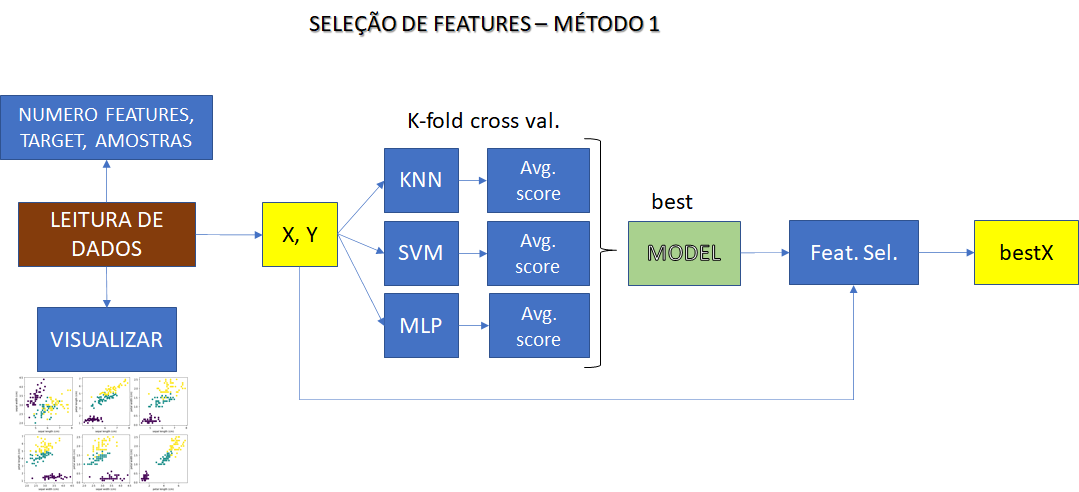

# Data-Set Reading and Pre-processing

In [7]:
# DIAGNOSIS DATA

path='C:/Users/diego/Google Drive/IA/datasets/respiratory_sound'

diagnosis_df = pd.read_csv(path+'/patient_diagnosis.csv', names=['Patient ID', 'Diagnosis'])

nPatients=diagnosis_df.shape[0]
print("number of patients: ",nPatients)

# CREATING A BINARY CLASSIFICATION

diagnosis_df['Binary_diagnosis'] = diagnosis_df['Diagnosis'].apply(lambda x: 0 if x =='Healthy'  else 1)
diagnosis_df.head()

number of patients:  126


,Patient ID,Diagnosis,Binary_diagnosis
0,101,URTI,1
1,102,Healthy,0
2,103,Asthma,1
3,104,COPD,1
4,105,URTI,1


In [8]:
df_demog = pd.read_csv(path+'/demographic_info.txt', names = 
                 ['Patient ID', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')
for p in range(df_demog.shape[0]):
    if np.isnan(df_demog['Adult BMI (kg/m2)'][p]):
        df_demog['Adult BMI (kg/m2)'][p] = 10000.0*df_demog['Child Weight (kg)'][p]/np.power(df_demog['Child Height (cm)'][p],2)
df_demog.head()

c:\users\diego\miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Patient ID,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,19.385777,19.0,99.0
1,102,0.75,F,18.389942,9.8,73.0
2,103,70.00,F,33.000000,NaN,NaN
3,104,70.00,F,28.470000,NaN,NaN
4,105,7.00,F,17.558299,32.0,135.0


In [15]:
df =  df_demog.join(diagnosis_df.set_index('Patient ID'), on = 'Patient ID', how = 'left')
df.head()

,Patient ID,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis,Binary_diagnosis
0,101,3.00,F,19.385777,19.0,99.0,URTI,1
1,102,0.75,F,18.389942,9.8,73.0,Healthy,0
2,103,70.00,F,33.000000,NaN,NaN,Asthma,1
3,104,70.00,F,28.470000,NaN,NaN,COPD,1
4,105,7.00,F,17.558299,32.0,135.0,URTI,1


Label Audio Data

In [16]:
def extract_annotation_data(file_name, root):
    
    # parsing filename
    tokens = file_name.split('_') 
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient ID', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    
    # reading start-end and type of sound
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    
    return (recording_info, recording_annotations)

In [17]:
root=path+'/txt/'

# varro os arquivos .txt no diretorio e pego o nome do arquivo sem a extensao
filenames = [f.split('.')[0] for f in os.listdir(path = root) if '.txt' in f]

info_list = []
rec_annotations = []
rec_annotations_dict = {}

for f in filenames:
    
    (info,annot) = extract_annotation_data(f, root)
    info_list.append(info)
    rec_annotations.append(annot)
    rec_annotations_dict[f] = annot
    
recording_info = pd.concat(info_list, axis = 0)
recording_info.head()

,Patient ID,Recording index,Chest location,Acquisition mode,Recording equipment
0,101,1b1,Al,sc,Meditron
0,101,1b1,Pr,sc,Meditron
0,102,1b1,Ar,sc,Meditron
0,103,2b2,Ar,mc,LittC2SE
0,104,1b1,Al,sc,Litt3200


In [18]:
# #rec_annotations_dict
# print(rec_annotations_dict[filenames[0]]['Start'])#
# print(rec_annotations_dict[filenames[0]]['End'])# 
# print(rec_annotations_dict[filenames[0]]['Crackles'])
# print(rec_annotations_dict[filenames[0]]['Wheezes'])

Pre-process audio files

In [19]:
def slice_audio(audiodata,samplerate,start,end):
    start = samplerate * start 
    end   = samplerate * end
    return audiodata[start:end]


In [20]:
def get_wav_files(audio_path):  
    wav_files = sorted([f for f in os.listdir(path = audio_path) if '.wav' in f])
    return wav_files

['URTI' 'Healthy' 'Asthma' 'COPD' 'LRTI' 'Bronchiectasis' 'Pneumonia'
 'Bronchiolitis']


<AxesSubplot:xlabel='Diagnosis', ylabel='count'>

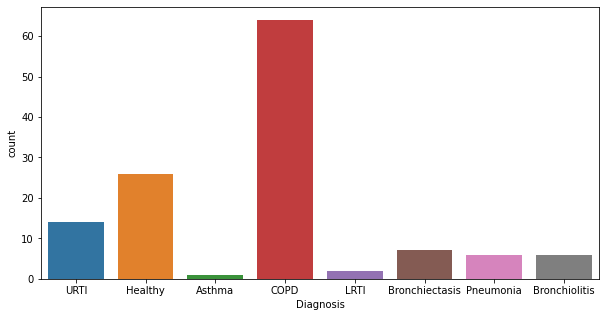

In [21]:
print(df['Diagnosis'].unique())
plt.figure(figsize=(10,5))
sns.countplot(df['Diagnosis'])

In [22]:
# df.to_csv("Diagnosis.csv",index=False)

# Clean unbalance classes (Asthma and LRTI)

In [23]:
# processed_df = df[ (df['Diagnosis'] !='Asthma') &  (df['Diagnosis'] !='LRTI') ]
processes_df=df

In [24]:
# plt.figure(figsize=(10,5))
# sns.countplot(processed_df['Diagnosis'])

In [25]:
# processed_df.head()

# AUDIO FILE READING, TRANSFORMING AND VISUALIZING

In [26]:
# auxiliary fuctions

def normalize(img):
    '''
    Normalizes an array 
    (subtract mean and divide by standard deviation)
    '''
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img

def normalize_dataset(X):
    '''
    Normalizes list of arrays
    (subtract mean and divide by standard deviation)
    '''
    normalized_dataset = []
    for img in X:
        normalized = normalize(img)
        normalized_dataset.append(normalized)
        
    return normalized_dataset

## BUILDING PRIMARY FEATURES (TIME DEPENDENT) BY SAMPLE (BY RECORDED FRAMES FROM PATIENTS) & TARGETS

In [27]:
audio_files = get_wav_files(os.path.join(path,"audio"))
n_audio_files = len(audio_files)

In [28]:
# SPLITTING TIME SERIES IN FRAMES ANNOTATED, INDEXED BY FILE NAME AND FRAME INDEX WITHIN THE AUDIO FILE

# PURE AUDIO

test_files=200 # n_audio_files #100

sample_wav=[] # list of audio strecht to classify
sample_file=[] # list of source file of each strecht
sample_window=[] # list of the number of the strecht within a patient's record
targets=[] # 0 - none, 1 - crackles, 2 - wheezes, 3 - both

for f in tqdm(audio_files[:test_files]):
    y, sr = librosa.core.load(os.path.join(path,"audio",f))
    ff=f.split('.')[0]   
    for s in range(len(rec_annotations_dict[ff])):
        Ed=int(sr*rec_annotations_dict[ff]['End'][s])+1
        if Ed<y.shape[0]:
            Bg=int(sr*rec_annotations_dict[ff]['Start'][s])
            sample_window.append(s)
            sample_file.append(ff)
            sample_wav.append(y[Bg:Ed])
            # binary classification
            aux=rec_annotations_dict[ff]['Crackles'][s]+2*rec_annotations_dict[ff]['Wheezes'][s]
            if aux>0:
                targets.append(1) 
            else:
                targets.append(0)
                
            # multiclass case
            #targets.append(rec_annotations_dict[ff]['Crackles'][s]+2*rec_annotations_dict[ff]['Wheezes'][s])
    
nSamples=len(targets)
print("nSamples: ",nSamples)
# print(targets)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:47<00:00,  1.19it/s]

nSamples:  1666


In [29]:
# Preprocessing parameters

sr = 44100 # Sampling rate

n_mels = 50

n_fft = 4096


melspectogram shape  (50, 51)
melspectogram shape  (50, 51)
melspectogram shape  (50, 51)
melspectogram shape  (50, 51)


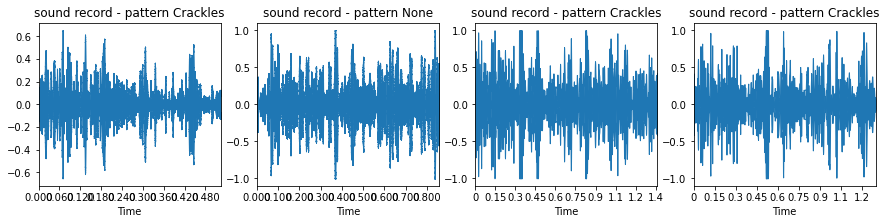

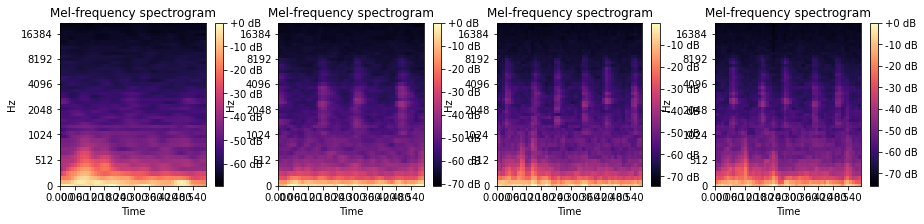

In [30]:
# plotting some  mel-frequency spectograms

# AUDIO

pattern =['None','Crackles','Wheezes','Crackles&Wheezes']

nex=4
k=35

fig2, a2 = plt.subplots(1,nex,figsize=(15,3))

ctr=0
for s in np.arange(k*nex,(k+1)*nex):
    librosa.display.waveplot(sample_wav[s], sr=sr,ax=a2[ctr])
#     a2[ctr].plot(np.arange(len(y))/sr,y)
    a2[ctr].set(title='sound record - pattern '+pattern[targets[s]])
    ctr+=1
plt.show

# MEL-FREQUENCY SPECTOGRAM

fig, a = plt.subplots(1,nex,figsize=(15,3))

ctr=0
for s in np.arange(k*nex,(k+1)*nex): 
    S = librosa.feature.melspectrogram(y=sample_wav[s], 
                                       sr=sr, 
                                       n_fft = 
                                       n_fft, 
                                       hop_length=int(len(sample_wav[s])/n_mels), 
                                       n_mels=n_mels)#, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr, ax=a[ctr]) # fmax=8000
    a[ctr].set(title='Mel-frequency spectrogram')
    fig.colorbar(img, ax=a[ctr], format='%+2.0f dB')
    print("melspectogram shape ",S.shape)
#     print("melspectogram DB shape ",S_dB.shape)
    ctr+=1
    
plt.show()

In [31]:
# MEASURING NUMBER OF SAMPLES BY MEDICAL SYMPTOMS IN THE DATA SAMPLE

Y=np.array(targets)

print("number of healty patients ",np.sum(Y==0))
print("number of non healthy patients ",np.sum(Y==1))
# print("number of patients with Crackles ",np.sum(Y==1))
# print("number of patients with Wheezes ",np.sum(Y==2))
# print("number of patients with Crackles  & Wheezes ",np.sum(Y==3))



number of healty patients  766
number of non healthy patients  900


In [32]:
# BUILDING FEATURE DATASET 

test_samples=nSamples

X=np.zeros((test_samples,n_mels*(n_mels+1)),dtype=float)
for s in range(test_samples): #nSamples):
    S = librosa.feature.melspectrogram(y=sample_wav[s], 
                                       sr=sr, 
                                       n_fft = n_fft,  
                                       n_mels=n_mels,
                                       hop_length=int(len(sample_wav[s])/n_mels))
    
    S_dB = librosa.power_to_db(S[:,:n_mels+1], ref=np.max)
    X[s]=S_dB.flatten()


nfeat=X.shape[1]
print("number of features ",nfeat)


number of features  2550


1>KNeighborsClassifier:, cv=0.801
2>RandomForestClassifier:, cv=0.826

best classifier with all features: RandomForestClassifier() accuracy 0.8259


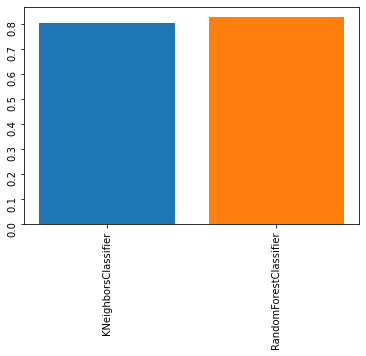

In [33]:
# COMPARISON OF MODELS WITH ALL FEATURES USING CROSS-VALIDATION

n_splits=10
model=Compare_Models(X[:test_samples,:],Y[:test_samples],n_splits=n_splits)


In [ ]:
# PAREI - OTHER KIND OF FEATURES ...
# chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
# rmse = librosa.feature.rmse(y=y)
# spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        

In [37]:
random_state=5

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=random_state)

print("training data set contains ",X_train.shape[0]," samples and test dataset ",X_test.shape[0],"\n")

# Declare a classifier class with the best model and best features
Model = model

# Fit the model with training data and target values
Model.fit(X_train, Y_train)

# Check with test data if everything is ok
Y_pred = Model.predict(X_test)
conf =  confusion_matrix(Y_pred,Y_test)
print("Confusion matrix on training data:")
print(conf)

T=0
for i in range(conf.shape[0]):
    T+=conf[i,i]
               
print("accuracy: ",T/np.sum(conf))


# plot_confusion_matrix(Model, X_test, Y_test)  
# plt.show()


training data set contains  1166  samples and test dataset  500 

Confusion matrix on training data:
[[181  41]
 [ 50 228]]
accuracy:  0.818
